In [269]:
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

In [270]:
import warnings
warnings.filterwarnings('ignore')

# Creating Dataset

In [271]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [272]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

In [273]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


In [274]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,True,False,True,False,True,False,False,True
1,True,False,False,True,False,True,True,False
2,False,True,False,True,True,False,False,True


In [275]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Looks_repulsive,Looks_handsome,Alcoholic_beverage_yes,Eloquence_average,Money_spent_lots,Money_spent_little,Alcoholic_beverage_no
0,True,False,True,True,False,True,False,False
1,False,False,True,True,False,False,True,False
2,False,False,True,False,True,True,False,True
3,False,True,False,False,True,False,True,True
4,False,True,False,True,False,True,False,False
5,True,True,False,True,False,True,False,False
6,False,False,True,True,True,True,False,False


1. What is the entropy $S_0$
 of the initial system? By system states, we mean values of the binary feature “Will_go” - 0 or 1 - two states in total.

In [276]:
y.value_counts()

Will_go
0    4
1    3
Name: count, dtype: int64

$$S_0 = -{4 \over 7} log_2 {4 \over 7} -{3 \over 7} log_2 {3 \over 7} = 0.985$$

In [277]:
s0 = -(4 / 7) * np.log2(4 / 7) - (3 / 7) * np.log2(3 / 7)
s0

0.9852281360342515

2. Let’s split the data by the feature “Looks_handsome”. What is the entropy
 of the left group - the one with “Looks_handsome”. What is the entropy
 in the opposite group? What is the information gain (IG) if we consider such a split?

In [278]:
y[df_train['Looks_handsome']]

0    0
1    1
2    0
6    0
Name: Will_go, dtype: int64

In [279]:
print(f'Entropy of left: {-(1 / 4) * np.log2(1 / 4) - (3 / 4) * np.log2(3 / 4)}')
s1 = -(1 / 4) * np.log2(1 / 4) - (3 / 4) * np.log2(3 / 4)

Entropy of left: 0.8112781244591328


In [280]:
y[~df_train['Looks_handsome']]

3    1
4    1
5    0
Name: Will_go, dtype: int64

In [281]:
print(f'Entropy of right: {-(1 / 3) * np.log2(1 / 3) - (2 / 3) * np.log2(2 / 3)}')
s2 = -(1 / 3) * np.log2(1 / 3) - (2 / 3) * np.log2(2 / 3)

Entropy of right: 0.9182958340544896


In [282]:
infromation_gain = s0 - (4 / 7) * s1 - (3 / 7) * s2
infromation_gain

0.12808527889139443

# Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [283]:
tree = DecisionTreeClassifier()
tree.fit(df_train, y)

DecisionTreeClassifier()

In [284]:
pred = tree.predict(df_test)
pred

array([0, 1, 1])

In [285]:
export_graphviz(
    decision_tree=tree,
    out_file='tree.dot',
    feature_names=df_train.columns,
    filled=True
)

In [286]:
!cat tree.dot

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="Money_spent_little <= 0.5\ngini = 0.49\nsamples = 7\nvalue = [4, 3]", fillcolor="#f8e0ce"] ;
1 [label="Looks_handsome <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]", fillcolor="#eca06a"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Eloquence_high <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]", fillcolor="#ffffff"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]", fillcolor="#399de5"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 1\nvalue = [1, 0]", fillcolor="#e58139"] ;
2 -> 4 ;
5 [label="gini = 0.0\nsamples = 3\nvalue = [3, 0]", fillcolor="#e58139"] ;
1 -> 5 ;
6 [label="gini = 0.0\nsamples = 2\nvalue = [0, 2]", fillcolor="#399de5"] ;
0 -> 6 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}

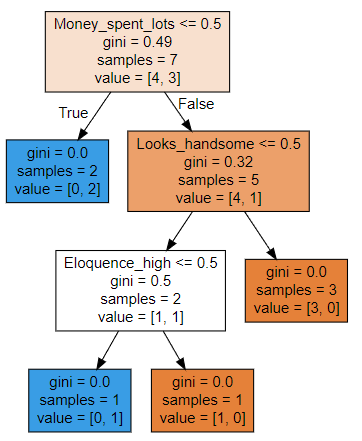

# Part 2. Functions for calculating entropy and information gain.

In [287]:
# Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label 1 if it is blue, 0 otherwise.

In [288]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [289]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

Implement Function to Calculate Shennon's entropy

In [290]:
from math import log


def entropy(a_list):
    lst = list(a_list)
    size = len(lst)
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0, 1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ / size * log(occ / size, 2)
    return entropy

In [291]:
from math import log

def entropy(a_list):
    a_list = list(a_list)
    classes = len(set(a_list))
    n = len(a_list)
    entropy = 0

    for i in set(a_list):
      occ = a_list.count(i)
      entropy -= occ / n * np.log2(occ / n)

    return entropy


In [292]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die
print(entropy(y[~df_train['Looks_handsome']]))

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156
0.9182958340544896


In [293]:
def information_gain(root, l_node, r_node):
  s0 = entropy(root)
  s1 = entropy(l_node)
  s2 = entropy(r_node)

  return s0 - (len(l_node) / len(root) * s1 +
               len(r_node) / len(root) * s2)

In [294]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

In [295]:
def information_gains(X, y):
  res = []

  for feature in X.columns:
    res.append(information_gain(y, y[X[feature] == 0], y[X[feature] == 1]))
  return res

Optional:

In [296]:
def build_tree(X, y, feature_names, depth=0):
  print(f'Current depth is {depth}')

  gains = information_gains(X, y)
  best_feature_index = np.argmax(gains)
  best_feature = feature_names[best_feature_index]
  print(f'{best_feature} was chosen as the best feature')

  x_left = X[X.iloc[:, best_feature_index] == 0]
  x_right = X[X.iloc[:, best_feature_index] == 1]

  y_left = y[X.iloc[:, best_feature_index] == 0]
  y_right = y[X.iloc[:, best_feature_index] == 1]

  l_entropy = entropy(y_left)
  r_entropy = entropy(y_right)

  print(f'Left entropy: {l_entropy} | Right entropy: {r_entropy}')
  print('-' * 60)

  if l_entropy > 0:
    build_tree(x_left, y_left, feature_names, depth+1)

  if r_entropy > 0:
    build_tree(x_right, y_right, feature_names, depth+1)

In [297]:
build_tree(df_train, y, df_train.columns)

Current depth is 0
Money_spent_lots was chosen as the best feature
Left entropy: 0.0 | Right entropy: 0.7219280948873623
------------------------------------------------------------
Current depth is 1
Looks_repulsive was chosen as the best feature
Left entropy: 0.0 | Right entropy: 1.0
------------------------------------------------------------
Current depth is 2
Eloquence_high was chosen as the best feature
Left entropy: 0.0 | Right entropy: 0.0
------------------------------------------------------------
